# NEVI

Using the Noisy Student self-learning techniques we will dive deep to search the bottom of the ocean.

In [184]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet_v2 import ResNet101V2, preprocess_input
from keras.applications.efficientnet_v2 import EfficientNetV2B1, preprocess_input
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.layers import ThresholdedReLU
from keras.models import load_model
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import PIL


By Type

In [156]:
TYPE_DATA_FOLDER_PATH  = "grouped_images_by_type"
AKIEC_DATA_FOLDER_PATH = "grouped_images_by_type\\akiec\\*"
BCC_DATA_FOLDER_PATH   = "grouped_images_by_type\\bcc\\*"
BKL_DATA_FOLDER_PATH   = "grouped_images_by_type\\bkl\\*"
DF_DATA_FOLDER_PATH    = "grouped_images_by_type\\df\\*"
MEL_DATA_FOLDER_PATH   = "grouped_images_by_type\\mel\\*"
NV_DATA_FOLDER_PATH    = "grouped_images_by_type\\nv\\*"
VASC_DATA_FOLDER_PATH  = "grouped_images_by_type\\vasc\\*"
TARGET_SIZE = (256, 256)
INPUT_SHAPE = (256, 256, 3)
BATCH_SIZE = 16

In [173]:
imgs_AKIEC  = glob.glob(AKIEC_DATA_FOLDER_PATH)
imgs_BCC    = glob.glob(BCC_DATA_FOLDER_PATH)
imgs_BKL    = glob.glob(BKL_DATA_FOLDER_PATH)
imgs_DF     = glob.glob(DF_DATA_FOLDER_PATH)
imgs_MEL    = glob.glob(MEL_DATA_FOLDER_PATH)
imgs_NV     = glob.glob(NV_DATA_FOLDER_PATH)
imgs_VASC   = glob.glob(VASC_DATA_FOLDER_PATH)

df_AKIEC = pd.DataFrame({'filename': imgs_AKIEC})
df_AKIEC['class'] = 'AKIEC'
df_BCC = pd.DataFrame({'filename': imgs_BCC})
df_BCC['class'] = 'BCC'
df_BKL = pd.DataFrame({'filename': imgs_BKL})
df_BKL['class'] = 'BKL'
df_DF = pd.DataFrame({'filename': imgs_DF})
df_DF['class'] = 'DF'
df_MEL = pd.DataFrame({'filename': imgs_MEL})
df_MEL['class'] = 'MEL'
df_NV = pd.DataFrame({'filename': imgs_NV})
df_NV['class'] = 'NV'
df_VASC = pd.DataFrame({'filename': imgs_VASC})
df_VASC['class'] = 'VASC'

AKIEC = 'AKIEC'
BCC = 'BCC'
BKL = 'BKL'
DF = 'DF'
MEL = 'MEL'
NV= 'NV'
VASC = 'VASC'

df = pd.concat([df_AKIEC, df_BCC, df_BKL, df_DF, df_MEL, df_NV, df_VASC])

df_train, df_temp = train_test_split(df, stratify=df['class'], test_size=.2)
df_val, df_test = train_test_split(df_temp, stratify=df_temp['class'], test_size=.5)

In [174]:


data_generator_vis = ImageDataGenerator()
flow_vis = data_generator_vis.flow_from_directory(
    TYPE_DATA_FOLDER_PATH,
    shuffle=False
)

Found 9773 images belonging to 7 classes.


In [175]:
data_generator_train = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90,
    shear_range=.1,
    brightness_range=[0.8,1.0]
)

data_generator_val = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

data_generator_test = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

TypeError: ImageDataGenerator.__init__() got an unexpected keyword argument 'class_names'

In [166]:
flow_train = data_generator_train.flow_from_dataframe(
    df_train,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

flow_val = data_generator_val.flow_from_dataframe(
    df_val,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
    
)

flow_test = data_generator_test.flow_from_dataframe(
    df_test,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 7818 validated image filenames belonging to 7 classes.
Found 977 validated image filenames belonging to 7 classes.
Found 978 validated image filenames belonging to 7 classes.


In [140]:
CLASS_MAP = {class_number: class_name.split('.')[0] for class_name, class_number in flow_vis.class_indices.items()}

In [141]:
EfficientNet = EfficientNetV2B1(
    include_top=False,
    weights='imagenet',
    input_shape=INPUT_SHAPE,
    pooling='max'
)

In [142]:
def get_model(base_model, activation="softmax", optimizer: str="adam", loss_function: str="CategoricalCrossentropy"):
    model = Sequential([
        base_model,
        Dropout(.2),
        Dense(7, activation=activation)
    ])
    
    for layer in model.layers[:-1]:
        layer.trainable=True
        
    model.compile(
        optimizer,
        loss_function,
        metrics=[
            "accuracy"
        ]
    )
    
    return model

In [75]:
model_eff = get_model(EfficientNet)

In [161]:
model_eff = load_model("model\\mymodel3.h5")

In [119]:
history_eff = model_eff.fit(
    flow_train,
    validation_data=flow_val,
    epochs=10
)

Epoch 1/10


KeyboardInterrupt: 

In [22]:
from keras import Model
Model.save(
    model_eff,
    filepath=".\\model\\mymodel3.h5",
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True,
)

In [168]:
_, resnet_accuracy = model_eff.evaluate(flow_test)

62/62 [==============================] - 2s 26ms/step - loss: 0.0767 - accuracy: 0.9693


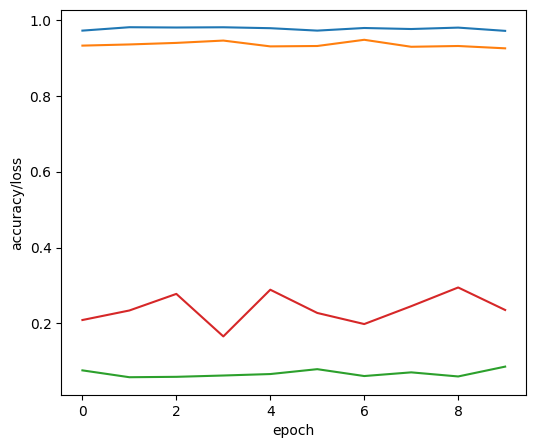

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.plot(history_eff.history["accuracy"])
plt.plot(history_eff.history["val_accuracy"])
plt.plot(history_eff.history["loss"])
plt.plot(history_eff.history["val_loss"])
plt.ylabel('accuracy/loss')
plt.xlabel('epoch')
plt.show()


C:\Users\artur\AppData\Local\Temp\ipykernel_18072\834430328.py:18: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model_eff.predict_generator(flow_test)


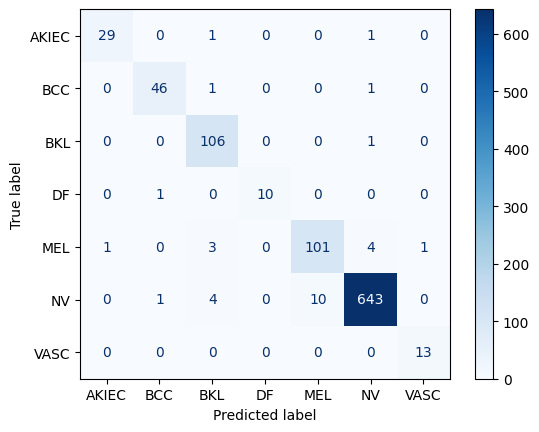

In [187]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# HAM_DATABASE_METADATA_DIR = "datasets\\HAM10000_metadata.csv"
ava_labels = [AKIEC, BCC, BKL, DF, MEL, NV, VASC]
# lb = preprocessing.LabelBinarizer()
# Y_bin = lb.fit_transform(ava_labels)
# data = pd.read_csv(HAM_DATABASE_METADATA_DIR)

# prediction = model_eff.predict(flow_test)
# prediction = prediction.argmax(axis=1)
# predicted_labels = [lb.classes_[i] for i in prediction]


# for 
# # entry = data.query("image_id == @image_id").dx.values[0]
# print(predicted_labels)

true_labels = flow_test.classes
predictions = model_eff.predict_generator(flow_test)
y_true = true_labels
y_pred = np.array([np.argmax(x) for x in predictions])
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=ava_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
custom_model = 0

By Severity

In [3]:
SEVERITY_DATA_FOLDER_PATH = "grouped_images_by_severity"
BENIGN_DATA_FOLDER_PATH = "grouped_images_by_severity\\benign\\*"
MALIGNANT_DATA_FOLDER_PATH = "grouped_images_by_severity\\malignant\\*"
TARGET_SIZE = (300, 300)
INPUT_SHAPE = (300, 300, 3)
BATCH_SIZE = 32

In [ ]:
imgs_benign = glob.glob(BENIGN_DATA_FOLDER_PATH)
imgs_malignant = glob.glob(MALIGNANT_DATA_FOLDER_PATH)

df_benign = pd.DataFrame({'filename': imgs_benign})
df_benign['class'] = 'benign'
df_malignant = pd.DataFrame({'filename': imgs_malignant})
df_malignant['class'] = 'melignant'

df = pd.concat([df_benign, df_malignant])

df_train, df_temp = train_test_split(df, stratify=df['class'], test_size=.2)
df_val, df_test = train_test_split(df_temp, stratify=df_temp['class'], test_size=.5)


In [5]:
np.random.seed(41)

data_generator_vis = ImageDataGenerator()
flow_vis = data_generator_vis.flow_from_directory(
    SEVERITY_DATA_FOLDER_PATH,
    shuffle=True
)

Found 9773 images belonging to 2 classes.


In [6]:
data_generator_train = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    rotation_range=5,
    shear_range=.1
)

data_generator_val = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

data_generator_test = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


In [7]:
flow_train = data_generator_train.flow_from_dataframe(
    df_train,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

flow_val = data_generator_val.flow_from_dataframe(
    df_val,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
    
)

flow_test = data_generator_test.flow_from_dataframe(
    df_test,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)



Found 7818 validated image filenames belonging to 2 classes.
Found 977 validated image filenames belonging to 2 classes.
Found 978 validated image filenames belonging to 2 classes.


In [8]:
CLASS_MAP = {class_number: class_name.split('.')[0] for class_name, class_number in flow_vis.class_indices.items()}

In [9]:
EfficientNet = EfficientNetV2B3(
    include_top=False,
    weights='imagenet',
    input_shape=INPUT_SHAPE,
    pooling='max'
)

52606240/52606240 [==============================] - 1s 0us/step


In [10]:
def get_model(base_model, activation: str="softmax", optimizer: str="adam", loss_function: str="CategoricalCrossentropy"):
    model = Sequential([
        base_model,
        Dropout(.2),
        Dense(2, activation=activation)
    ])
    
    for layer in model.layers[:-1]:
        layer.trainable=False
        
    model.compile(
        optimizer,
        loss_function,
        metrics=[
            "accuracy"
        ]
    )
    
    return model

In [11]:
model_eff = get_model(EfficientNet)

In [12]:
model_eff.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b3 (Function  (None, 1536)             12930622  
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 2)                 3074      
                                                                 
Total params: 12,933,696
Trainable params: 3,074
Non-trainable params: 12,930,622
_________________________________________________________________


In [13]:
history_rsnet = model_eff.fit(
    flow_train,
    validation_data=flow_val,
    epochs=50
)

Epoch 1/50
245/245 [==============================] - 100s 374ms/step - loss: 0.9385 - accuracy: 0.7545 - val_loss: 0.5391 - val_accuracy: 0.7707
Epoch 2/50
245/245 [==============================] - 90s 366ms/step - loss: 0.7505 - accuracy: 0.7746 - val_loss: 0.5439 - val_accuracy: 0.7697
Epoch 3/50
245/245 [==============================] - 94s 383ms/step - loss: 0.6553 - accuracy: 0.7883 - val_loss: 0.7297 - val_accuracy: 0.8117
Epoch 4/50
245/245 [==============================] - 97s 395ms/step - loss: 0.6100 - accuracy: 0.7883 - val_loss: 0.4822 - val_accuracy: 0.8291
Epoch 5/50
245/245 [==============================] - 96s 392ms/step - loss: 0.5934 - accuracy: 0.7948 - val_loss: 0.3963 - val_accuracy: 0.8096
Epoch 6/50
245/245 [==============================] - 96s 392ms/step - loss: 0.5854 - accuracy: 0.7988 - val_loss: 0.4559 - val_accuracy: 0.7984
Epoch 7/50
245/245 [==============================] - 90s 365ms/step - loss: 0.5224 - accuracy: 0.8001 - val_loss: 0.7273 - val_a

KeyboardInterrupt: 

In [ ]:
_, resnet_accuracy = model_eff.evaluate(flow_test)